# logistic_regression.ipynb

#### A code to use the logistic regression strategy to classify using max flux, max flux / average flux, eta and V

#### Import all the dependencies and generic setup

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
import os
import glob
import numpy as np
import pandas as pd
from scipy import optimize
import tkp.db
import logging
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
import sys
sys.path.append('../')
from dblogin import * # This file contains all the variables required to connect to the database
from database_tools import dbtools
from tools import tools
from plotting import plot_varib_params as pltvp
from machine_learning import train_logistic_regression
from machine_learning import generic_tools

#### The input data and thresholds

In [2]:
tests = False
plots = False
lda = 0.1
path='ml_csv_files/'
stableData = path+'stable_sources.csv'
simulatedData = path+'sim_*_trans_data.csv'

#### setting the options for the scipy optimise function

In [3]:
options = {'full_output': True, 'maxiter': 5000, 'ftol': 1e-4, 'maxfun': 5000, 'disp': True}

#### Load the data and give appropriate labels

In [4]:
all_data = generic_tools.load_data(stableData,simulatedData)

#### Load the simulations and only keep those with a full lightcurve and with variability parameters > 0

In [5]:
all_data=all_data.loc[(all_data['ttype'] == 2) & (all_data['V']>0.) & (all_data['eta']>0.)]


#### put the training data into the format required for the training

In [6]:
data=all_data.apply(lambda row:[row['#Runcat'],np.log10(row['eta']),np.log10(row['V']),row['flux'],row['fluxrat'],row['variable']],axis=1)
data = data.as_matrix()

#### Train algorithm using the full dataset

In [7]:
shuffled = np.matrix(generic_tools.shuffle_datasets(data))
shuffledTMP=shuffled[:,1:].astype(float)
ids=shuffled[:,0]
X, y = train_logistic_regression.create_X_y_arrays(np.matrix(np.array(shuffledTMP)))
initial_theta=np.zeros((X.shape[1]))
theta, cost, _, _, _ = optimize.fmin(lambda t: train_logistic_regression.reg_cost_func(t,X,y.T,lda), initial_theta, **options)

../machine_learning/train_logistic_regression.py:27: RuntimeWarning: divide by zero encountered in log
  J=(1/float(m))*(-y.dot(np.log(sig)) - (1-y).dot(np.log(1-sig)))


Optimization terminated successfully.
         Current function value: 0.006419
         Iterations: 680
         Function evaluations: 1144


#### Classify the full dataset

In [8]:
tp, fp, fn, tn, classified = train_logistic_regression.classify_data(X,y.T,theta)
classified=np.array(np.c_[ids,classified,y])
classified=pd.DataFrame(data=classified, columns=['#Runcat','eta','V','flux','fluxrat','classified','label'])
classified=classified.apply(lambda row:[row['#Runcat'],10.**(float(row['eta'])),10.**(float(row['V'])),float(row['flux']),float(row['fluxrat']),row['classified'],row['label']],axis=1)

#### Calculate the precision and recall

In [9]:
precision, recall = generic_tools.precision_and_recall(tp,fp,fn)
print "Logistic Regression Model: "+str(theta)
print "Precision: "+str(precision)+", Recall: "+str(recall)

Logistic Regression Model: [-3.01522552  1.93325598  6.3971683   0.12643366  0.80927512]
Precision: 0.985714285714, Recall: 0.8625


In [10]:
classified.loc[(classified['classified'] == 'FP')]

,#Runcat,eta,V,flux,fluxrat,classified,label
11831,12697.0,8.725815,2.175489,0.304853,4.260498,FP,0.0
15171,12831.0,0.255564,2.191882,0.060168,3.644709,FP,0.0
19089,12697.0,0.104535,3.038042,0.035532,5.568587,FP,0.0
23557,8127.0,0.231248,4.829839,0.035242,4.415212,FP,0.0


#### Create eta V plot showing training results

(-6.0, 1.0)

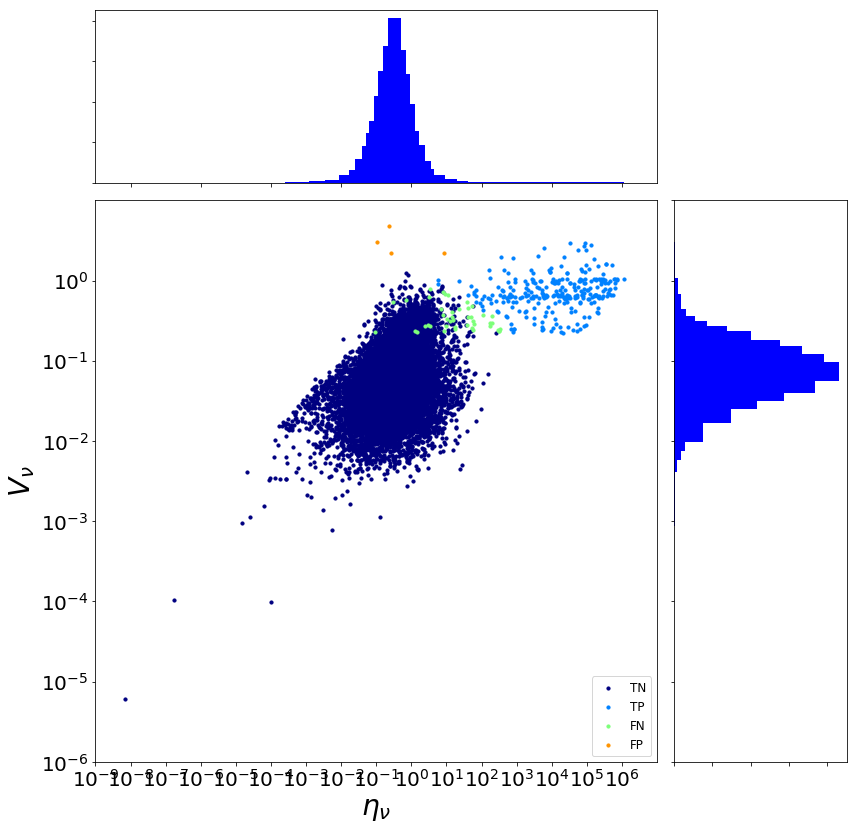

In [11]:
plotdata=classified
frequencies=plotdata.classified.unique()
col = pltvp.make_cmap(frequencies)

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(12,12))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=28)
plt.ylabel(r'$V_{\nu}$', fontsize=28)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_var=np.log10(plotdataTMP['eta'])
    ydata_var=np.log10(plotdataTMP['V'])
    axScatter.scatter(xdata_var, ydata_var,color=col[i], s=10., zorder=5)

x = np.log10(plotdata['eta'])
y = np.log10(plotdata['V'])

axHistx.hist(x, bins=pltvp.make_bins(x), normed=1, histtype='stepfilled', color='b')
axHisty.hist(y, bins=pltvp.make_bins(y), normed=1, histtype='stepfilled', orientation='horizontal', color='b')

freq_labels=[f for f in frequencies]
axScatter.legend(freq_labels,loc=4, prop=fontP)
xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=20)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=20)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())


#### Create the diagnostic plot

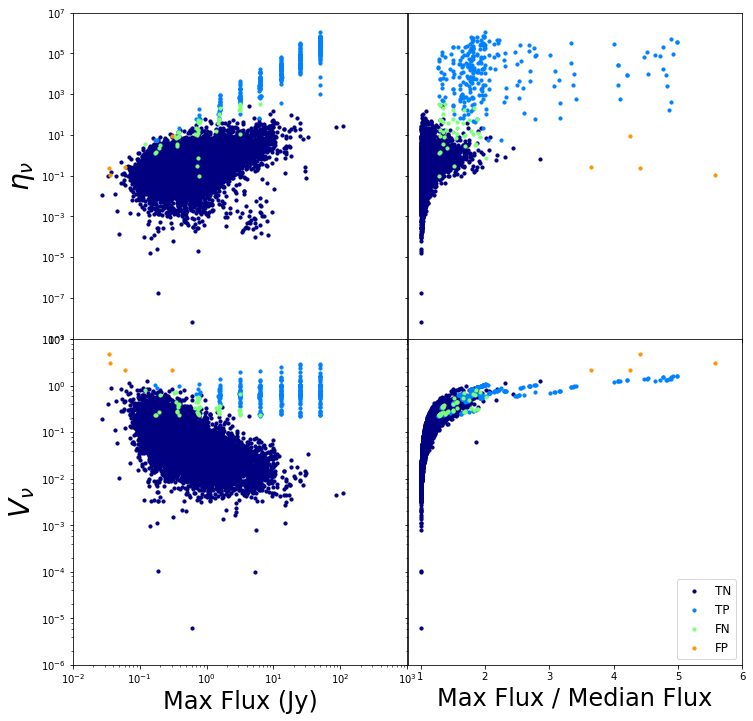

In [12]:
fig = plt.figure(1,figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fontP = FontProperties()
fontP.set_size('large')
fig.subplots_adjust(hspace = .001, wspace = 0.001)
ax1.set_ylabel(r'$\eta_\nu$', fontsize=28)
ax3.set_ylabel(r'$V_\nu$', fontsize=28)
ax3.set_xlabel('Max Flux (Jy)', fontsize=24)
ax4.set_xlabel('Max Flux / Median Flux', fontsize=24)

for i in range(len(frequencies)):
    plotdataTMP=plotdata.loc[(plotdata['classified']==frequencies[i])]
    xdata_ax3=plotdataTMP['flux']
    xdata_ax4=plotdataTMP['fluxrat']
    ydata_ax1=plotdataTMP['eta']
    ydata_ax3=plotdataTMP['V']
    ax1.scatter(xdata_ax3, ydata_ax1,color=col[i], s=10., zorder=5)
    ax2.scatter(xdata_ax4, ydata_ax1,color=col[i], s=10., zorder=6)
    ax3.scatter(xdata_ax3, ydata_ax3,color=col[i], s=10., zorder=7)
    ax4.scatter(xdata_ax4, ydata_ax3,color=col[i], s=10., zorder=8)
    ax4.legend(freq_labels, loc=4, prop=fontP)

Xax3=plotdata['flux']
Xax4=plotdata['fluxrat']
Yax1=plotdata['eta']
Yax3=plotdata['V']
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax4.set_yscale('log')
xmin_ax3=10.**(int(np.log10(min(Xax3))-1.1))
xmax_ax3=10.**(int(np.log10(max(Xax3))+1.2))
xmin_ax4=0.8
xmax_ax4=int(max(xdata_ax4)+0.5)
ymin_ax1=10.**(int(np.log10(min(Yax1))-1.1))
ymax_ax1=10.**(int(np.log10(max(Yax1))+1.2))
ymin_ax3=10.**(int(np.log10(min(Yax3))-1.1))
ymax_ax3=10.**(int(np.log10(max(Yax3))+1.2))
ax1.set_ylim(ymin_ax1,ymax_ax1)
ax3.set_ylim(ymin_ax3,ymax_ax3)
ax3.set_xlim(xmin_ax3,xmax_ax3)
ax4.set_xlim(xmin_ax4,xmax_ax4)
ax1.set_xlim( ax3.get_xlim() )
ax4.set_ylim( ax3.get_ylim() )
ax2.set_xlim( ax4.get_xlim() )
ax2.set_ylim( ax1.get_ylim() )
ax1.xaxis.set_major_formatter(nullfmt)
ax4.yaxis.set_major_formatter(nullfmt)
ax2.xaxis.set_major_formatter(nullfmt)
ax2.yaxis.set_major_formatter(nullfmt)